# Optimization


## Introduction

Now that we have our forecasts, it's time to convert them into actual positions. We have a lot of free parameters in making this decision, so you should always take in-sample results with a huge grain of salt.

I'll try a few options:

* Minimize Risk
* Maximize utility function with size and turnover constraints.
* Minimize greatest drawdown

Minimizing risk is quadratic, and some versions of the utility function can be solved with convex optimization, too.

The appropriate benchmark return is the prevailing short-term USD interest rate, i.e., what you would get if you just left dollars in the bank. We really want to look at risk-adjusted returns, as FX prices are subject to occasional blow-outs.

I'm going to take advantage of the fact that we have simulated distributions of forecast y values, rather than just point estimates, to adjust our risk expectations. More on this below.

NB. I'm switching to Python for the optimization stage. I want to do the work in TensorFlow, and the R package for TensorFlow is just a wrapper around the Python package.

Generally speaking, I prefer R for development and Python for production. I think R graphics are still far easier to use than what Python has to offer, especially if you like to use "trellis," AKA faceted, AKA small multiples graphs. However, R's object-oriented syntaxes (there are two) are difficult to use and clearly bolted-on. In my opinion, once you get to a level of complication that would favor objects instead of functional programming, you're better off using Python. Another minor quibble: RStudio lets me use Vi keybindings, Jupyter notebook doesn't.

In [3]:
from scipy import optimize
import numpy as np

In [20]:
import tensorflow as tf
import pandas as pd
y_sim = pd.read_csv("../data/forecast_ys.csv", parse_dates=[3],
                   index_col=[3,1,0])

/home/charles/py_3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [208]:
endo = pd.read_csv("../data/endo.csv", index_col=0, parse_dates=True)
endo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 555 entries, 2007-01-12 to 2017-08-25
Data columns (total 11 columns):
AUD    555 non-null float64
CAD    555 non-null float64
CHF    555 non-null float64
CZK    555 non-null float64
EUR    555 non-null float64
GBP    555 non-null float64
JPY    555 non-null float64
NOK    555 non-null float64
NZD    555 non-null float64
SEK    555 non-null float64
TRY    555 non-null float64
dtypes: float64(11)
memory usage: 52.0 KB


In [6]:
%matplotlib inline

## On Y Covariance

We actually specified our expected covariance of asset returns as an input into our Stan model. Now, we also have the covariance of our simulated forecasts.

I'm tempted to say that we should just take our input covariance estimate again, because **the covariance of the forecast is not the forecast of the covariance**. In particular, the scale of the forecast covariance will be substantially lower than the scale of our input covariance, because we have filtered everything through our factor-based regression.

At the same time, if we just threw out the covariance of the forecast, we would lose a lot of our assumptions about how correlated assets are to one another. The true relationship between assets is more complicated than a simple covariance matrix, but perhaps we can approximate by using the correlations of the simulated forecast, but the realized variance we used as an input into Stan.

So, our $\Sigma$ for optimization will be defined as $\sigma_y'\rho_\hat{y}\sigma_y$, where $\sigma_y$ is the square root of the diagonal of our input endogenous covariance matrix, and $\rho_\hat{y}$ is the correlation of the simulated forecast returns.

We can test this methodology against just using the input covariance estimate to see which is more robust. I would expect $\Sigma$ as defined above to result in a more diversified, more timid portfolio than just pairing the forecasts with the input covariance.

If we'd done something more complicated for our input covariance than just exponentially weighting realized returns, this step might not be so useful.

In [42]:
forecast_rho = y_sim.unstack("asset").groupby(level=0).corr().reset_index(level=1)
forecast_rho.pop("level_1")
forecast_rho.head()

value                                                    \
asset                  AUD       CAD       CHF       CZK       EUR       GBP   
Date       asset                                                               
2010-01-08 AUD    1.000000  0.745177  0.571161  0.693413  0.711485  0.681142   
           CAD    0.745177  1.000000  0.483942  0.555506  0.589827  0.602568   
           CHF    0.571161  0.483942  1.000000  0.734745  0.885201  0.575235   
           CZK    0.693413  0.555506  0.734745  1.000000  0.825459  0.635096   
           EUR    0.711485  0.589827  0.885201  0.825459  1.000000  0.651844   

                                                                    
asset                  JPY       NOK       NZD       SEK       TRY  
Date       asset                                                    
2010-01-08 AUD    0.046399  0.715046  0.873067  0.665758  0.698551  
           CAD    0.021020  0.673813  0.742599  0.615040  0.682045  
           CHF    0.441419  0.714893  0.585889  0.668956  0.341470  
           CZK    0.226447  0.727521  0.686712  0.783695  0.586175  
           EUR    0.412769  0.821493  0.682958  0.743935  0.526097

In [71]:
y_cov = pd.read_csv("../data/y_cov.csv", index_col=[0,1,2],
                    parse_dates=["Date"])

Let's see how different $\rho_\hat{y}$ is from $\rho_y$.

In [115]:
def cov2cor(x):
    inv = np.linalg.inv(np.diag(np.sqrt(np.diag(x))))
    return inv.dot(x).dot(inv)

In [163]:
def corrplot(covhat,covrel):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm
    
    vals = np.triu(covhat.as_matrix())+np.tril(covrel)
    np.fill_diagonal(vals,1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(vals, vmin=-1, vmax=1, cmap=cm.Spectral_r)
    plt.title('Rho_yhat (upper) vs Rho_y (lower)')
    labels=covhat.index.tolist()
    ticks = np.arange(0,len(labels),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax)
    plt.show()


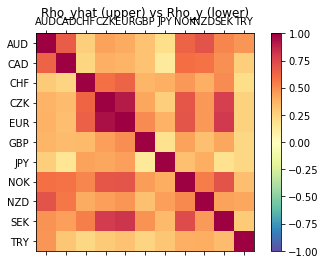

In [166]:
dt = pd.Timestamp("2017-08-25")
corrplot(forecast_rho.loc[dt],cov2cor(y_cov.loc[dt].unstack()))

Huh. All positive, and if anything $\rho_\hat{y}$ is a bit *less* correlated. I expected a bigger difference than this.

Nonetheless, I'll proceed as planned. Convert $\rho_\hat{y}$ to $\Sigma_\hat{y}$ using the realized variance.

In [206]:
forecast_cov = pd.DataFrame(index=forecast_rho.index, 
                            columns=forecast_rho.columns)
for dt in forecast_cov.index.get_level_values(0):
    sd = np.diag(np.sqrt(np.diag(y_cov.loc[dt].unstack())))
    forecast_cov.loc[dt] = sd.dot(forecast_rho.loc[dt]).dot(sd)

## Basic Utility Function
We get the Markowitz efficient portfolio by minimizing:
$$ w' \Sigma w - q R' w $$
Where $w$ is the vector of portfolio weights, $\Sigma$ is the covariance matrix, $R$ is the vector of returns, and $q$ is a "risk tolerance" scalar. When $q$ is zero, we are simply minimizing risk.

Typically, you'll see this formula with a constraint that $\sum{w} = 1$, but the math doesn't require it. When you're investing in a portfolio of currency exposures, your sum of weights is actually always 0 if you include the numeraire (i.e. USD). 

However, obviously, the minimum risk portfolio with no constraint on $\sum{w}$ is going to be doing absolutely nothing. We'll instead try to maximize returns given a risk limit of 20% annualized and a gross leverage limit to keep our problem in reasonable territory. There are plenty of people trading FX with higher leverage than that, but I hope they are not setting their portfolios on a weekly basis.

We are also not currently accounting for slippage, i.e. the amount we will move prices by implementing our positions. It's not likely to be significant for FX, but it's still good practice to penalize turnover. Conceptually, we are playing trends that should last longer than our periodicity suggests, even if the forecasts are changing relatively rapidly.

The CVX documentation goes over some options [here](http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb).

We'll now need a point estimate for forecast returns. We can use the median of the simulated $\hat{y}$ that we generated in Stan.

In [75]:
y_hat = y_sim.groupby(["asset","Date"]).value.median().unstack(level=0)

There is a closed-form solution to this problem, and there's no need to involve TensorFlow. We could implement it with straight linear algebra, or `scipy.optimize`, but I'm a fan of CXVPY. The whole "disciplined convexity" paradigm forces you to think about what you're doing.

In [92]:
np.sqrt(52)*np.diag(y_cov.loc[y_hat.index[0]].unstack())

array([ 0.00579986,  0.00292413,  0.00182536,  0.00406727,  0.00181339,
        0.00268614,  0.00253078,  0.00293239,  0.00536701,  0.0041779 ,
        0.00447027])

In [77]:
import cvxpy

In [218]:
def optim_maxret(yhat, cov, Lmax=2.5, risk_max=0.005,
                   n_assets=y_hat.shape[1],
                asset_names=y_hat.columns):
    """Maximize return based on a portfolio
    
    NB. Constraining on absolute value of exposure is not a convex problem, so we're going to limit
    """
    w = cvxpy.Variable(n_assets)
    risk = cvxpy.quad_form(w, cov) * np.sqrt(52)
    ret = yhat.T*w
    
    prob = cvxpy.Problem(cvxpy.Maximize(ret),
                     constraints=[cvxpy.sum_squares(w) <= Lmax,
                                 risk < risk_max])
    prob.solve()
    return np.squeeze(np.asarray(w.value))

The risk_max constraint is not being hit on this one, which means that it's irrelevant whether we use the forecast correlation or the correlation implied from the historical asset covariance matrix.

Nevertheless, let's generate the portfolios for the entire backtest period and see how we do.

In [248]:
y_hat.columns[1:]

Index(['CAD', 'CHF', 'CZK', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'TRY'], dtype='object', name='asset')

In [232]:
forecast_cov.loc[dt].values[:-1,:-1].shape

(10, 10)

In [253]:
weights_markowitz = pd.DataFrame(columns=y_hat.columns,
                                index=y_hat.index)
for dt in weights_markowitz.index:
    weights_markowitz.loc[dt] = optim_maxret(y_hat.loc[dt].values,
                                            forecast_cov.loc[dt].values,
                                            n_assets=11,asset_names=y_hat.columns)

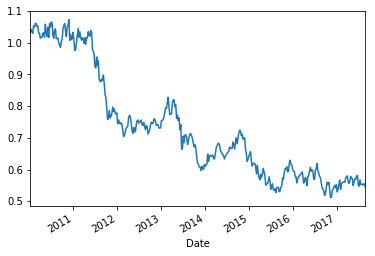

In [254]:
(1+weights_markowitz.multiply(endo).sum(axis=1).dropna()).cumprod().plot()

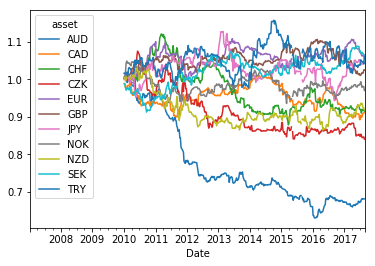

In [255]:
(1+weights_markowitz.multiply(endo)).dropna(axis=1,how='all').cumprod().plot()

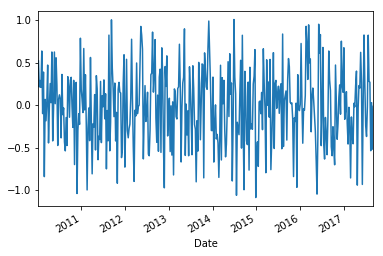

In [258]:
weights_markowitz.AUD.plot()

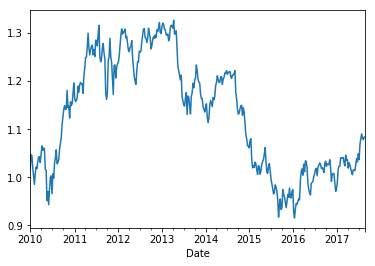

In [256]:
(1+endo.AUD.loc['2010':]).cumprod().plot()

We know that the risk is significantly greater than the covariance matrices imply, because the returns aren't truly Gaussian. Perhaps we should be trying to minimize tail risk instead.

## Minimize Drawdowns